In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords

import scikitplot as skplt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
uk_pol_final = pd.read_csv('uk_pol_final.csv')

In [4]:
uk_pol_final.head()

,speaker,party,date,subject,text
0,Mark Isherwood,Conservative,2006-01-10,Fuel Poverty,The Chartered Institute of Housing Cymru state...
1,Chuka Umunna,Labour,2011-12-02,Universities UK,Thank you for that kind welcome. I am hugely g...
2,Chuka Umunna,Labour,2012-01-12,High Pay Commission,Thank you for that introduction Michael and to...
3,Chuka Umunna,Labour,2012-06-26,Hub Westminster,"Thank you for that introduction, and thank you..."
4,Chuka Umunna,Labour,2012-05-28,UCATT Conference,"Conference, thank you so very much for invitin..."


In [3]:
uk_pol_df = uk_pol_final[(uk_pol_final.party=='Conservative')|(uk_pol_final.party=='Labour')]

In [4]:
train_df, test_df = train_test_split(uk_pol_df, stratify=uk_pol_df['party'], test_size=0.3, random_state=1)

In [5]:
stop = stopwords.words('english')
stop = stop + ['conservative','conservatives','tory','tories','labour','corbyn']

In [7]:
train_df.party.value_counts(normalize=True)

Conservative    0.72
Labour          0.28
Name: party, dtype: float64

## Multinomial Naive Bayes:

In [8]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode',stop_words=stop)),
#     ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 

pipeline.fit(train_df.text, train_df.party)
print(pipeline.score(train_df.text, train_df.party))
print(cross_val_score(pipeline, train_df.text, train_df.party, cv=5).mean())
print(pipeline.score(test_df.text, test_df.party))

0.9247761194029851
0.8071777553634734
0.8328690807799443


In [9]:
predictions = pipeline.predict(test_df.text)
pd.DataFrame(confusion_matrix(test_df.party, predictions,
                              labels=test_df.party.unique()),
             columns=test_df.party.unique(),
             index=test_df.party.unique())

,Conservative,Labour
Conservative,458,59
Labour,61,140


### Mulitnomial Naive Bayes performed better than baseline.

## Bernouilli Naive Bayes with binarised count vector:

In [10]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode',stop_words=stop, binary=True)),
#     ('tfidf', TfidfTransformer()),
    ('cls', BernoulliNB())
]) 

pipeline.fit(train_df.text, train_df.party)
print(pipeline.score(train_df.text, train_df.party))
print(cross_val_score(pipeline, train_df.text, train_df.party, cv=5).mean())
print(pipeline.score(test_df.text, test_df.party))

0.8674626865671642
0.7552336265635041
0.7604456824512534


In [11]:
predictions = pipeline.predict(test_df.text)
pd.DataFrame(confusion_matrix(test_df.party, predictions,
                              labels=test_df.party.unique()),
             columns=test_df.party.unique(),
             index=test_df.party.unique())

,Conservative,Labour
Conservative,454,63
Labour,109,92


### Bernouilli Naive Bayes performed pretty much at baseline.

## Logistic Regression:

In [12]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode',stop_words=stop)),
#     ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression())
]) 

pipeline.fit(train_df.text, train_df.party)
print(pipeline.score(train_df.text, train_df.party))
print(cross_val_score(pipeline, train_df.text, train_df.party, cv=5).mean())
print(pipeline.score(test_df.text, test_df.party))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8453921793938773
0.8746518105849582


In [13]:
predictions = pipeline.predict(test_df.text)

In [14]:
pd.DataFrame(confusion_matrix(test_df.party, predictions,
                              labels=test_df.party.unique()),
             columns=test_df.party.unique(),
             index=test_df.party.unique())

,Conservative,Labour
Conservative,489,28
Labour,62,139


In [15]:
print(classification_report(test_df.party, predictions))

              precision    recall  f1-score   support

Conservative       0.89      0.95      0.92       517
      Labour       0.83      0.69      0.76       201

   micro avg       0.87      0.87      0.87       718
   macro avg       0.86      0.82      0.84       718
weighted avg       0.87      0.87      0.87       718



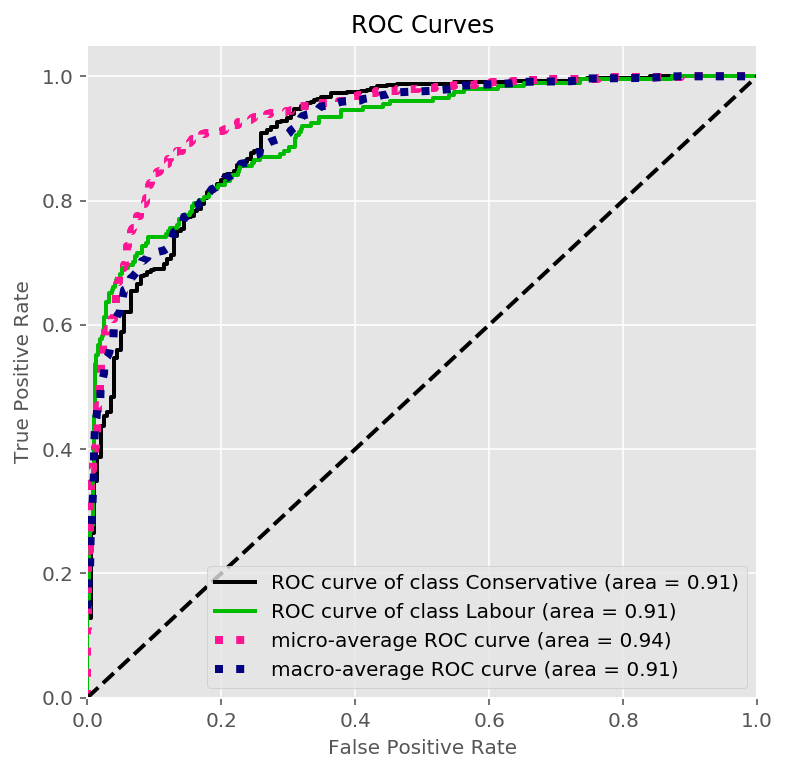

In [16]:
probas = pipeline.predict_proba(test_df.text)

fig, ax = plt.subplots(figsize=(6,6))

skplt.metrics.plot_roc(test_df.party, probas, ax=ax)
plt.show();

### Logistic Regression performed significantly above baseline. Scores were higher without tf-idf norm.

## Random Forest:

In [17]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode',stop_words=stop)),
#     ('tfidf', TfidfTransformer()),
    ('randf', RandomForestClassifier())
]) 

pipeline.fit(train_df.text, train_df.party)
print(pipeline.score(train_df.text, train_df.party))
print(cross_val_score(pipeline, train_df.text, train_df.party, cv=5).mean())
print(pipeline.score(test_df.text, test_df.party))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9844776119402985
0.7582009648081236
0.745125348189415


In [18]:
predictions = pipeline.predict(test_df.text)
pd.DataFrame(confusion_matrix(test_df.party, predictions,
                              labels=test_df.party.unique()),
             columns=test_df.party.unique(),
             index=test_df.party.unique())

,Conservative,Labour
Conservative,500,17
Labour,166,35


### Random Forest performed a bit better than baseline.

As Logistic Regression worked the best I'm going to have a look at the predictions we got on the test set.

In [6]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode',stop_words=stop)),
#     ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression())
]) 

pipeline.fit(train_df.text, train_df.party)
predictions = pipeline.predict(test_df.text)
test_df['predicted'] = predictions
test_df['match'] = test_df.apply(lambda x: 1 if x['party']==x['predicted'] else 0, axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

In [7]:
pd.DataFrame(confusion_matrix(test_df.party, predictions,
                              labels=test_df.party.unique()),
             columns=test_df.party.unique(),
             index=test_df.party.unique())

,Conservative,Labour
Conservative,487,30
Labour,63,138


In [8]:
print(classification_report(test_df.party, predictions))

              precision    recall  f1-score   support

Conservative       0.89      0.94      0.91       517
      Labour       0.82      0.69      0.75       201

   micro avg       0.87      0.87      0.87       718
   macro avg       0.85      0.81      0.83       718
weighted avg       0.87      0.87      0.87       718



Having a quick look at how the accuracy of predictions changes over time.

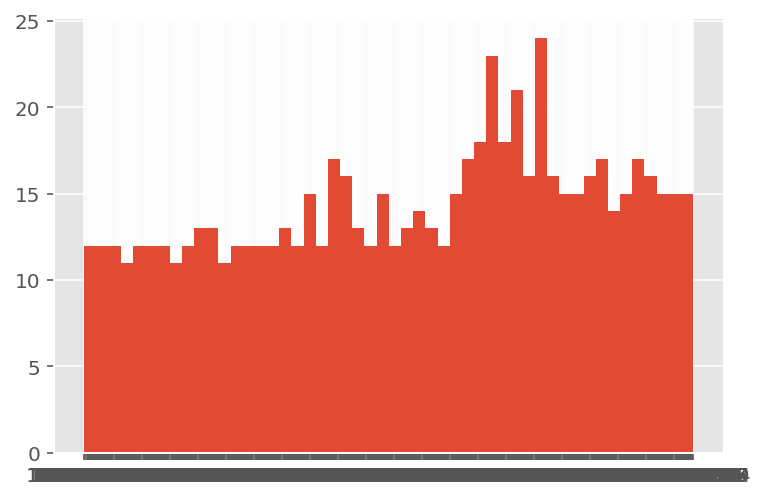

In [9]:
test_df.date.hist(bins=50);

We don't have a massive number of speeches from before 2000 so limit the range for a more sensible result:

In [10]:
test_df.date = pd.to_datetime(test_df.date)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


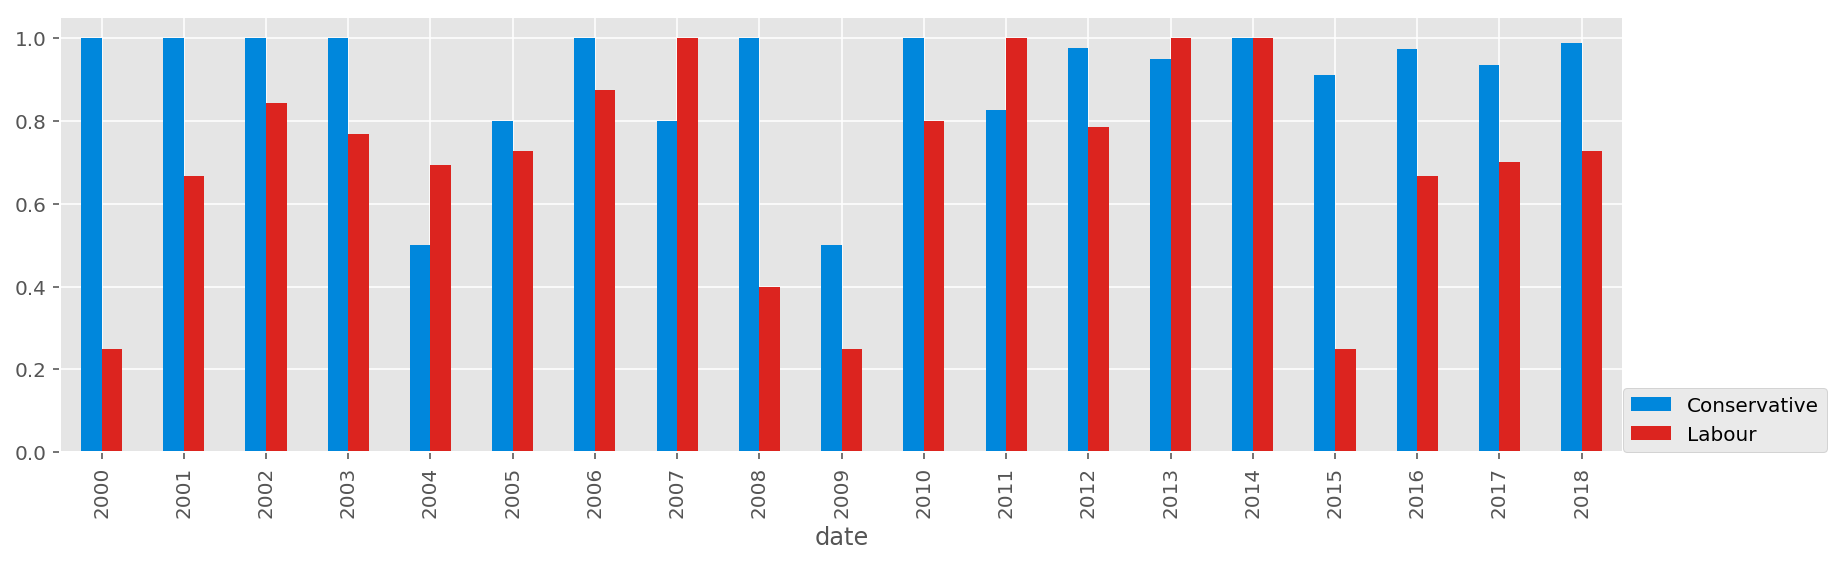

In [11]:
fig, ax = plt.subplots(figsize=(14,4))

test_df[test_df.date.dt.year>1999].groupby([test_df.date.dt.year,'party'])['match'].mean().unstack().plot(kind='bar',
                                                                                                          ax=ax, 
                                                                                                          color=['#0087DC','#DC241f'])

plt.legend(loc=(1,0))
plt.show();

The model is generally better at predicting Conservative speeches than Labour (as we saw from the classification report), but there doesn't seem to be any correlation to date.

In [12]:
test_df.head()

,speaker,party,date,subject,text,predicted,match
1756,Jeremy Hunt,Conservative,2013-01-16,Policy Exchange,"In 1953, when the NHS was just five years old,...",Conservative,1
1636,Matthew Hancock,Conservative,2018-01-25,Speech in Davos,Thank you for the introduction and for invitin...,Conservative,1
593,Andrea Leadsom,Conservative,2018-03-20,Violence Against Women in Politics,"Deeds, not words’. That, as you all know, was ...",Conservative,1
2224,Francis Maude,Conservative,2014-01-29,Sprint 14,It’s a pleasure to welcome you here today. I r...,Conservative,1
1698,Nick Herbert,Conservative,2011-09-28,Police Effectiveness,Introduction My thanks to the Police Foundatio...,Conservative,1


In [13]:
df = test_df.groupby(['speaker']).match.agg(['mean','count'])

In [14]:
speakers = df[df['count']>8].reset_index().merge(test_df[['speaker','party']]).drop_duplicates()

In [15]:
speakers

,speaker,mean,count,party
0,Alan Milburn,0.800000,10,Labour
10,Boris Johnson,1.000000,11,Conservative
21,David Cameron,0.964286,56,Conservative
77,Ed Miliband,1.000000,9,Labour
86,George Osborne,1.000000,17,Conservative
103,Gordon Brown,0.842105,19,Labour
122,Iain Duncan Smith,0.818182,11,Conservative
133,Jeremy Corbyn,0.909091,11,Labour
144,Jeremy Hunt,1.000000,11,Conservative
155,John Hutton,0.777778,9,Labour


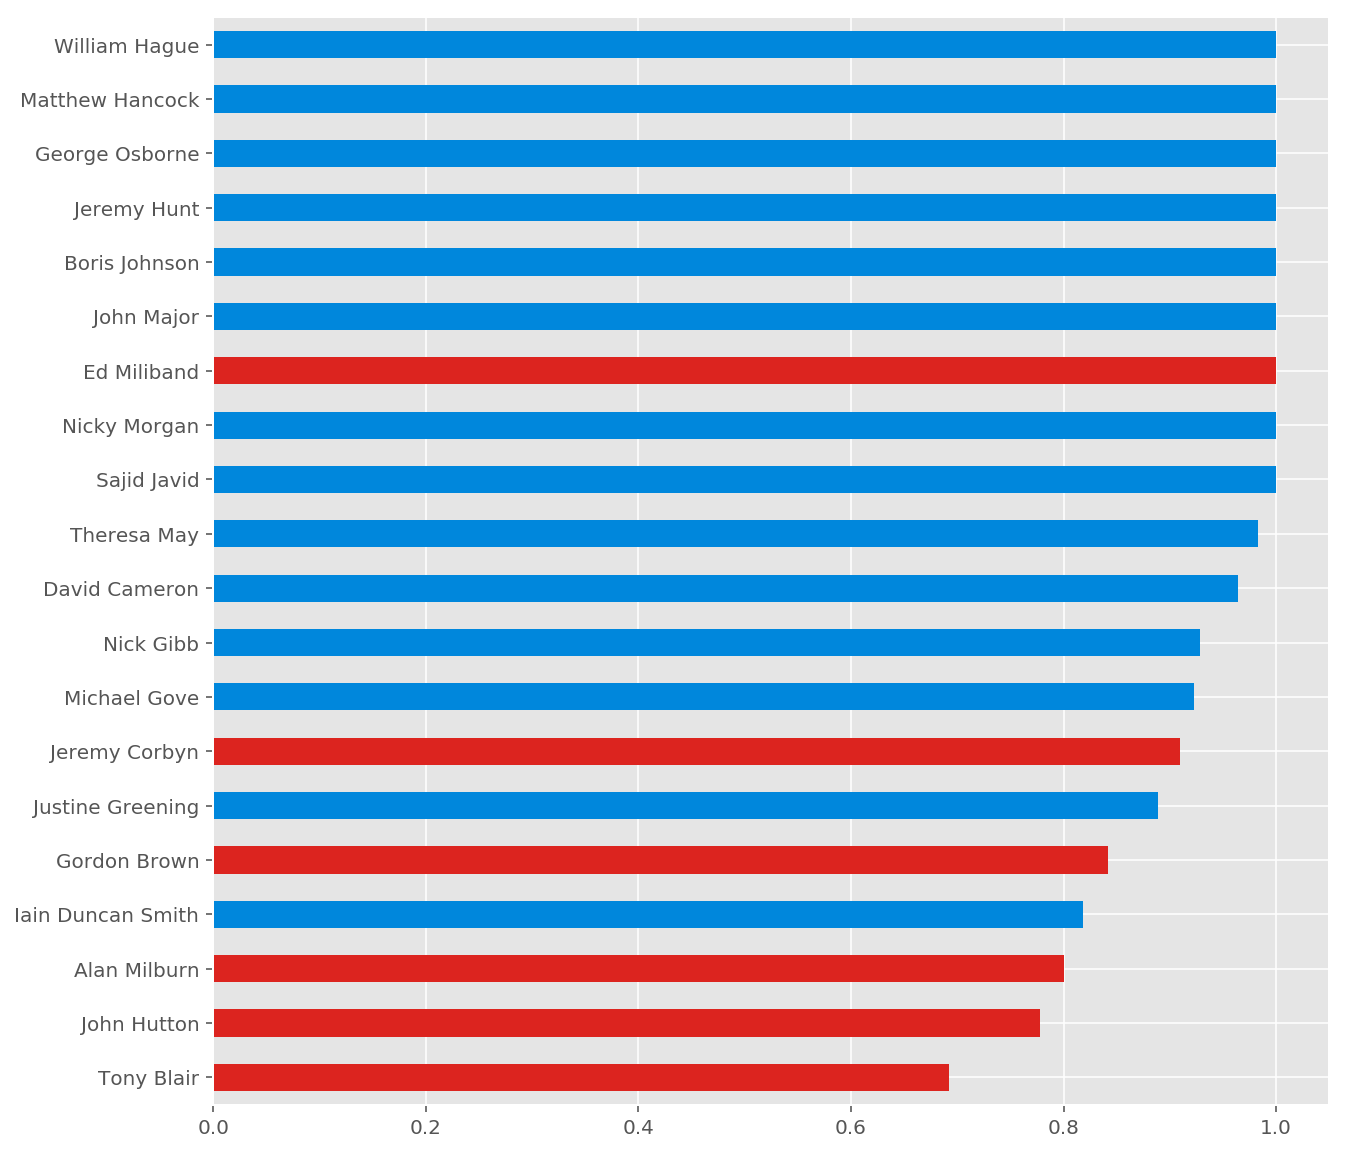

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

speakers.sort_values('mean')['mean'].plot(kind='barh', ax=ax, color=list(np.where(speakers.sort_values('mean').party=='Conservative','#0087DC','#DC241f')))
ax.set_yticklabels(speakers.sort_values('mean').speaker)

plt.show();

The weak model is better at identifying Conservative speakers than Labour speakers. Interestingly it appears that the model has less certainty for centrists such as Tony Blair and David Cameron than politicians generally identified as more extreme like Jeremy Corbyn and Boris Johnson.

In [17]:
vect = pipeline.named_steps['vect']
logreg = pipeline.named_steps['logreg']

In [18]:
coef_df = pd.DataFrame({'word':vect.get_feature_names(),'coef':logreg.coef_.flatten()})

In [19]:
coef_df['abs_coef'] = np.abs(coef_df.coef)

In [20]:
coef_df.sort_values('coef',ascending=False).head(10)

,word,coef,abs_coef
8911,cuts,0.565940,0.565940
28686,round,0.329555,0.329555
7731,conference,0.320964,0.320964
7875,consensus,0.292575,0.292575
11778,employment,0.287481,0.287481
36456,workers,0.277978,0.277978
31294,standards,0.277937,0.277937
11552,election,0.273533,0.273533
7882,consequences,0.267966,0.267966
14610,george,0.262772,0.262772


In [21]:
coef_df.sort_values('coef',ascending=True).head(10)

,word,coef,abs_coef
12472,everyone,-0.406754,0.406754
34134,uk,-0.331737,0.331737
29480,sector,-0.309321,0.309321
8410,country,-0.303333,0.303333
8550,create,-0.279035,0.279035
32639,taxes,-0.272413,0.272413
20924,may,-0.263249,0.263249
32138,support,-0.261060,0.261060
17266,increase,-0.260966,0.260966
31010,spend,-0.257506,0.257506


In [22]:
sparse = vect.transform(uk_pol_df.text)
all_words = pd.DataFrame(sparse.toarray(),columns=vect.get_feature_names())
all_words['speaker'] = uk_pol_df.speaker

In [23]:
all_words.groupby('speaker').sum().loc['Theresa May'].sort_values(ascending=False)[:20]

people        1983
nhs           1278
government    1106
work          1024
need           991
country        965
new            888
one            847
health         811
want           789
services       757
make           747
today          716
care           679
know           632
us             629
local          626
britain        618
public         607
year           606
Name: Theresa May, dtype: int64

In [24]:
con_text = ' '.join([x for x in uk_pol_df[uk_pol_df.party=='Conservative'].text])

In [25]:
lab_text = ' '.join([x for x in uk_pol_df[uk_pol_df.party=='Labour'].text])

In [26]:
wordcloud = WordCloud().generate(con_text)

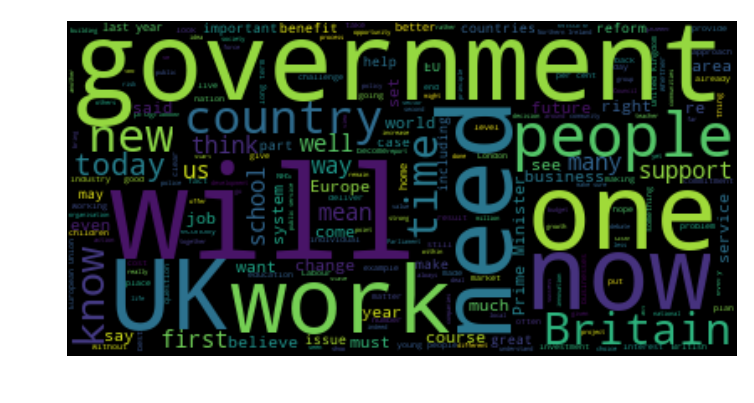

In [27]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

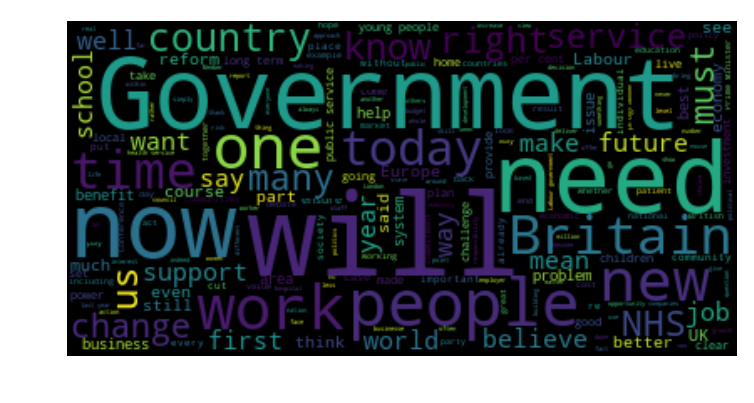

In [28]:
wordcloud2 = WordCloud().generate(lab_text)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
tory_coefs = coef_df.sort_values('coef',ascending=False).head(20)
labour_coefs = coef_df.sort_values('coef',ascending=True).head(20)

In [30]:
tory_coefs['factor'] = tory_coefs.coef.map(lambda x: int(100*x))
labour_coefs['factor'] = labour_coefs.coef.map(lambda x: -int(100*x))

In [31]:
tory_coef_list = []
for ind, row in tory_coefs.iterrows():
    for i in range(row.factor):
        tory_coef_list.append(row.word)
        
labour_coef_list = []
for ind, row in labour_coefs.iterrows():
    for i in range(row.factor):
        labour_coef_list.append(row.word)

In [42]:
def blue_color_func(word, font_path, font_size, position, orientation, random_state=None):
    return "#0087DC"

def red_color_func(word, font_path, font_size, position, orientation, random_state=None):
    return "#DC241f"

In [33]:
tory_coef_words = ' '.join(tory_coef_list)
labour_coef_words = ' '.join(labour_coef_list)

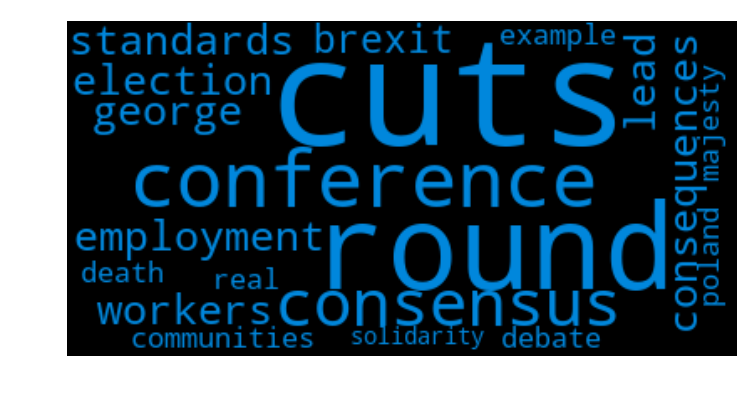

In [41]:
tory_coef_wordcloud = WordCloud(collocations=False, color_func=blue_color_func).generate(tory_coef_words)
plt.imshow(tory_coef_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

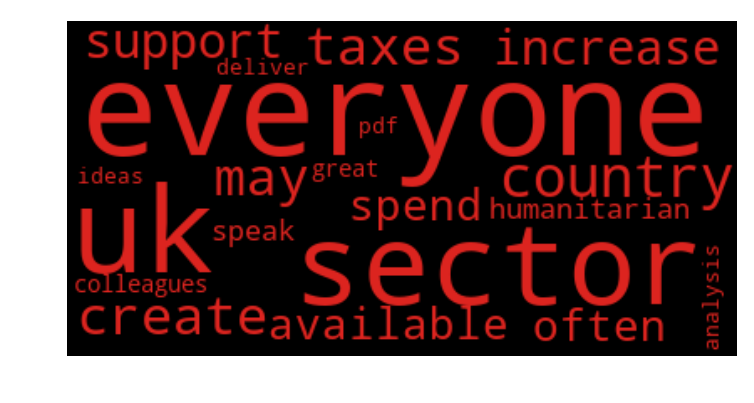

In [43]:
labour_coef_wordcloud = WordCloud(collocations=False, color_func=red_color_func).generate(labour_coef_words)
plt.imshow(labour_coef_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()